# Reddit Natural Language Processing Using TensorFlow

In [1]:
import requests

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np

import matplotlib.pyplot as plt

import random

import string

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_hub as hub

## Data Preparation

### Initialize Reddit API

Resources:
* https://www.reddit.com/dev/api/
* https://medium.com/geekculture/utilizing-reddits-api-8d9f6933e192

In [2]:
CLIENT_ID = 'pWZ7Y4r0YUyMqk7pyJB94A'
SECRET_KEY = 'RlsNxO0ID9GmUBwRNBThZEE1UEymrQ'

auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)

with open('pw.txt', 'r') as f:
    pw = f.read()

data = {
    'grant_type': 'password',
    'username': 'DirtierHarbor2',
    'password': pw
}

headers = {'User-Agent': 'MyAPI/0.0.1'}

res = requests.post('https://www.reddit.com/api/v1/access_token', auth=auth, data=data, headers=headers)

TOKEN = res.json()['access_token']

headers['Authorization'] = 'bearer ' + TOKEN

api = 'https://oauth.reddit.com'

### Data Exploration

In [3]:
# Try looking into the top post of the r/python subreddit
raw_data = requests.get('{}/r/python/top'.format(api), headers=headers, params={'limit': 1}).json()
raw_data

{'kind': 'Listing',
 'data': {'after': 't3_13bloxf',
  'dist': 1,
  'modhash': None,
  'geo_filter': '',
  'children': [{'kind': 't3',
    'data': {'approved_at_utc': None,
     'subreddit': 'Python',
     'selftext': "Hey Everyone! 👋  \nOver the past two months, I've been hard at work developing a new Python frontend web framework, and I'm excited to announce its first minimal release: Starfyre.  \nStarfyre is a Python web framework designed to simplify front-end web application development. Starfyre offers a user-friendly and powerful solution for crafting dynamic web applications by seamlessly bridging back-end and front-end development in the Python ecosystem. By unlocking untapped potential in Python front-end development, Starfyre empowers developers to create engaging and interactive applications easily.\n\nSome of the key features are:  \n\\- Single-file reactive components  \n\\- Built-in state management   \n\\- Server-side rendering  \n\\- PyML, a custom JSX-like language  \

In [4]:
# show keys in json response
keys_outer = [key for key in raw_data]
print(f"Keys in json response:\n{keys_outer}")
print(f"There are {len(keys_outer)} keys in raw data top-level")

Keys in json response:
['kind', 'data']
There are 2 keys in raw data top-level


In [5]:
# Investigate the json starting from top level
kind = raw_data[keys_outer[0]]
data = raw_data[keys_outer[1]]
print(f"'{keys_outer[0]}'", f"= {kind}" if type(kind) == int or type(kind) == str else " contains no values" if kind is None else f" contains {len(kind)} values")
print(f"'{keys_outer[1]}'", f"= {data}" if type(data) == int or type(data) == str else " contains no values" if data is None else f" contains {len(data)} values")

'kind' = Listing
'data'  contains 6 values


In [6]:
# show keys in 'data' dict
keys_data = [key for key in data]
print(f"Keys in 'data':\n{keys_data}")
print(f"There are {len(keys_data)} keys in 'data'")

Keys in 'data':
['after', 'dist', 'modhash', 'geo_filter', 'children', 'before']
There are 6 keys in 'data'


In [7]:
# Investigate the 'data' dict
after = data[keys_data[0]]
dist = data[keys_data[1]]
modhash = data[keys_data[2]]
geo_filter = data[keys_data[3]]
children = data[keys_data[4]]
before = data[keys_data[5]]
print(f"'{keys_data[0]}'", f"= {after}" if type(after) == int or type(after) == str else " contains no values" if after is None else f" contains {len(after)} values")
print(f"'{keys_data[1]}'", f"= {dist}" if type(dist) == int or type(dist) == str else " contains no values" if dist is None else f" contains {len(dist)} values")
print(f"'{keys_data[2]}'", f"= {modhash}" if type(modhash) == int or type(modhash) == str else " contains no values" if modhash is None else f" contains {len(modhash)} values")
print(f"'{keys_data[3]}'", f"= {geo_filter}" if type(geo_filter) == int or type(geo_filter) == str else " contains no values" if geo_filter is None else f" contains {len(geo_filter)} values")
print(f"'{keys_data[4]}'", f"= {children}" if type(children) == int or type(children) == str else " contains no values" if children is None else f" contains {len(children)} values")
print(f"'{keys_data[5]}'", f"= {before}" if type(before) == int or type(before) == str else " contains no values" if before is None else f" contains {len(before)} values")

'after' = t3_13bloxf
'dist' = 1
'modhash'  contains no values
'geo_filter' = 
'children'  contains 1 values
'before'  contains no values


In [8]:
# show keys in 'children' dict
keys_children = [key for key in children[0]]
print(f"Keys in 'children':\n{keys_children}")
print(f"There are {len(keys_children)} keys in 'children'")

Keys in 'children':
['kind', 'data']
There are 2 keys in 'children'


In [9]:
# Investigate the 'children' dict
kind_children = children[0][keys_children[0]]
data_children = children[0][keys_children[1]]
print(f"'{keys_children[0]}'", f"= {kind_children}" if type(kind_children) == int or type(kind_children) == str else " contains no values" if kind_children is None else f" contains {len(kind_children)} values")
print(f"'{keys_children[1]}'", f"= {data_children}" if type(data_children) == int or type(data_children) == str else " contains no values" if data_children is None else f" contains {len(data_children)} values")

'kind' = t3
'data'  contains 109 values


In [10]:
# show keys in 'children/data' dict
keys_data_children = [key for key in data_children]
print(f"Keys in 'children':\n{keys_data_children}")
print(f"There are {len(keys_data_children)} keys in 'children/data'")

Keys in 'children':
['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'top_awarded_type', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'upvote_ratio', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'is_created_from_ads_ui', 'author_premium', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'gildings', 'post_hint', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'removed_by_category', 'banned_by', 'author_flair_type', 'domain', 'allow_live_comme

In [11]:
# What does the 'children/data' dict look like?
data_children

{'approved_at_utc': None,
 'subreddit': 'Python',
 'selftext': "Hey Everyone! 👋  \nOver the past two months, I've been hard at work developing a new Python frontend web framework, and I'm excited to announce its first minimal release: Starfyre.  \nStarfyre is a Python web framework designed to simplify front-end web application development. Starfyre offers a user-friendly and powerful solution for crafting dynamic web applications by seamlessly bridging back-end and front-end development in the Python ecosystem. By unlocking untapped potential in Python front-end development, Starfyre empowers developers to create engaging and interactive applications easily.\n\nSome of the key features are:  \n\\- Single-file reactive components  \n\\- Built-in state management   \n\\- Server-side rendering  \n\\- PyML, a custom JSX-like language  \n\\- Support for both client-side and server-side Python  \n\\- Integrated CSS and HTML support  \n\\- Ability to write JavaScript if need be  \n\\- Famili

In [12]:
# Cleaning data to pack as a DataFrame
for i in data_children:
    if type(data_children.get(i)) is list or type(data_children.get(i)) is dict:
        data_children[i] = None

In [13]:
# Create DataFrame
df = pd.DataFrame(data_children, index=[0])
df.info(), df.columns

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 0 to 0
Columns: 109 entries, approved_at_utc to is_video
dtypes: bool(31), float64(3), int64(10), object(65)
memory usage: 663.0+ bytes


(None,
 Index(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved',
        'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext',
        ...
        'author_flair_text_color', 'permalink', 'parent_whitelist_status',
        'stickied', 'url', 'subreddit_subscribers', 'created_utc',
        'num_crossposts', 'media', 'is_video'],
       dtype='object', length=109))

In [14]:
df

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,None,Python,"Hey Everyone! 👋 \nOver the past two months, I...",t2_5xu8opjs,False,None,0,False,Starfyre - A Python Web Framework for creating...,None,...,None,/r/Python/comments/13bloxf/starfyre_a_python_w...,all_ads,False,https://www.reddit.com/r/Python/comments/13blo...,1125956,1.683544e+09,0,None,False


It looks like there are some variables that I don't think are relavent.  

Try saving only a small fraction of available variables next time.

### Testing Data Extraction

Take what was learned previously about the structure of the data; now attempt to store data into dataframes

The variables that will be analyzed for the rest of the project will be:
* subreddit
* title
* selftext
* upvote_ratio
* score
* total_awards_recieved

In [15]:
# Set subreddit to read from
SUBREDDIT = 'random'

# Set limit per subreddit request
LIMIT = 5

# Setting up dataframe
df = pd.DataFrame({'subreddit': [],
                   'title': [],
                   'upvote_ratio': [],
                   'score': [],
                   'total_awards_received': []})

In [16]:
# Send a request again with different parameters
raw_data = requests.get('{}/r/{}'.format(api, SUBREDDIT), headers=headers, params={'limit': LIMIT}).json()

In [17]:
# parse data and append to dataframe
for i, _ in enumerate(raw_data['data']['children']):
  post = raw_data['data']['children'][i].get('data')
  df_2 = pd.DataFrame([{'subreddit': post['subreddit'],
                        'title': post['title'],
                        'upvote_ratio': post['upvote_ratio'],
                        'score': post['score'],
                        'total_awards_received': post['total_awards_received']}])
  df = pd.concat([df, df_2], ignore_index=True)

In [18]:
# Check the dataframe
df

,subreddit,title,upvote_ratio,score,total_awards_received
0,TrueAnon,Episode 289: The Game Is Afoot (trailer),1.00,14.0,0.0
1,TrueAnon,North Korean propaganda encouraging young men ...,0.98,92.0,0.0
2,TrueAnon,oh my god,0.96,74.0,0.0
3,TrueAnon,Too much internet for today.,0.96,150.0,0.0
4,TrueAnon,The Ukrainian delegation unfurls two flags at ...,0.93,282.0,0.0
5,TrueAnon,Evidence of Texas Mall Shooter’s Neo-Nazism,0.96,163.0,0.0


### Bringing it all together

Pull even more information using the Reddit API so that there is sufficient data to start model building

In [19]:
def new_data_to_dataframe(df, subreddit='random', sortby='', limit=5):
    raw_data = requests.get('{}/r/{}/{}'.format(api, subreddit, sortby), headers=headers, params={'limit': limit}).json()
    for i, _ in enumerate(raw_data['data']['children']):
        post = raw_data['data']['children'][i].get('data')
        df_2 = pd.DataFrame([{'subreddit': post['subreddit'],
                              'title': post['title'],
                              'upvote_ratio': post['upvote_ratio'],
                              'score': post['score'],
                              'total_awards_received': post['total_awards_received']}])
        df = pd.concat([df, df_2], ignore_index=True)
    return df

In [20]:
%%time
# Set subreddit to read from
SUBREDDIT = ['python','mildlyinfuriating','news','gaming','facepalm','aww','cats','technicallythetruth','memes','oddlyspecific']
# Set sort results by
SORTBY = ['best','controversial']
# Set limit per subreddit request
LIMIT = 1000
# Clear DataFrame
df = pd.DataFrame({'subreddit': [],
                   'title': [],
                   'upvote_ratio': [],
                   'score': [],
                   'total_awards_received': []})

for subreddit in SUBREDDIT:
    for sortby in SORTBY:
        df = new_data_to_dataframe(df, subreddit=subreddit, sortby=sortby, limit=LIMIT)

CPU times: total: 1.7 s
Wall time: 28 s


In [21]:
df.head()

,subreddit,title,upvote_ratio,score,total_awards_received
0,Python,Sunday Daily Thread: What's everyone working o...,0.59,2.0,0.0
1,Python,Tuesday Daily Thread: Advanced questions,0.63,2.0,0.0
2,Python,Starfyre - A Python Web Framework for creating...,0.94,378.0,1.0
3,Python,Textual 0.24.0 adds a Select control,0.92,52.0,0.0
4,Python,deptry 0.10.0 - A tool to detect issues with y...,0.91,15.0,0.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subreddit              1736 non-null   object 
 1   title                  1736 non-null   object 
 2   upvote_ratio           1736 non-null   float64
 3   score                  1736 non-null   float64
 4   total_awards_received  1736 non-null   float64
dtypes: float64(3), object(2)
memory usage: 67.9+ KB


In [23]:
df.describe()

,upvote_ratio,score,total_awards_received
count,1736.000000,1736.000000,1736.000000
mean,0.835386,2469.213134,0.078341
std,0.171318,8743.080577,0.657191
min,0.080000,0.000000,0.000000
25%,0.750000,11.000000,0.000000
50%,0.900000,48.000000,0.000000
75%,0.960000,434.500000,0.000000
max,1.000000,118425.000000,20.000000


In [24]:
# Save to data to csv
df.to_csv("reddit_data.csv", index=False)

### Data Preprocessing

Read in the dataset and split it into training and testing sets.  

Also, examine the distribution of quantitative data.

In [25]:
df = pd.read_csv("reddit_data.csv")
df.head()

,subreddit,title,upvote_ratio,score,total_awards_received
0,Python,Sunday Daily Thread: What's everyone working o...,0.59,2.0,0.0
1,Python,Tuesday Daily Thread: Advanced questions,0.63,2.0,0.0
2,Python,Starfyre - A Python Web Framework for creating...,0.94,378.0,1.0
3,Python,Textual 0.24.0 adds a Select control,0.92,52.0,0.0
4,Python,deptry 0.10.0 - A tool to detect issues with y...,0.91,15.0,0.0


Shuffling the dataset because it may help prevent models from learning any order of the dataset

In [26]:
# Shuffle dataframe
df = df.sample(frac=1, random_state=123)
df.head()

,subreddit,title,upvote_ratio,score,total_awards_received
956,aww,[OC] The only way to stop her from crawling in...,0.97,38.0,0.0
1667,oddlyspecific,Saw this getting blood drawn today.,0.96,392.0,0.0
1059,aww,"It’s his cake day today, and He knew what was ...",0.88,43.0,0.0
1172,cats,Sweetcorn lover🤗,0.79,11.0,0.0
784,facepalm,Bella Hadid Getting Emotional For Not Having A...,0.73,42.0,0.0


In [27]:
# Split dataframe into training and test sets
TEST_SIZE = 0.2
train_df = df[:int(len(df)*(1-TEST_SIZE))]
test_df = df[-int(len(df)*TEST_SIZE):]
print(f"Training samples: {len(train_df)}\nTesting samples: {len(test_df)}")

Training samples: 1388
Testing samples: 347


In [28]:
# How many samples belong to which subreddit?
train_df.subreddit.value_counts()

subreddit
mildlyinfuriating      169
facepalm               167
memes                  165
aww                    163
cats                   159
gaming                 141
news                   111
technicallythetruth    110
oddlyspecific          105
Python                  98
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

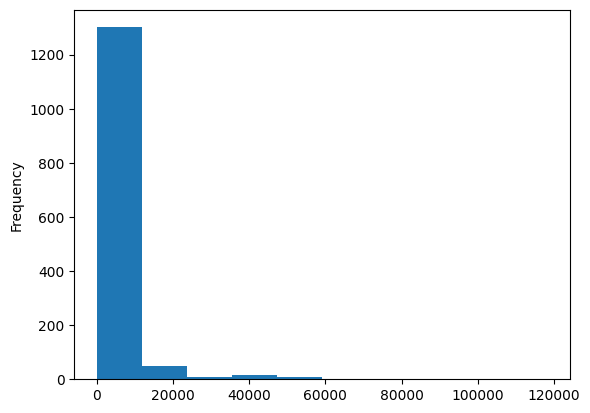

In [29]:
train_df.score.plot.hist()

<Axes: ylabel='Frequency'>

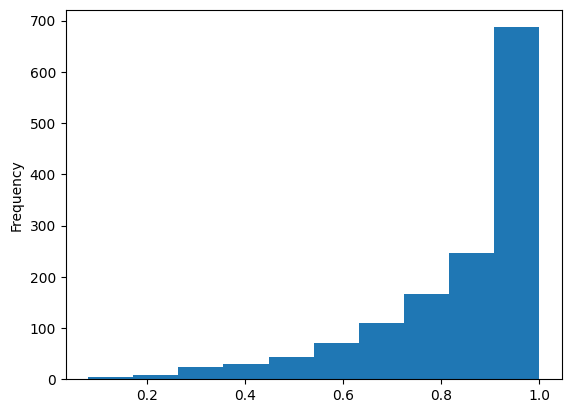

In [30]:
train_df.upvote_ratio.plot.hist()

<Axes: ylabel='Frequency'>

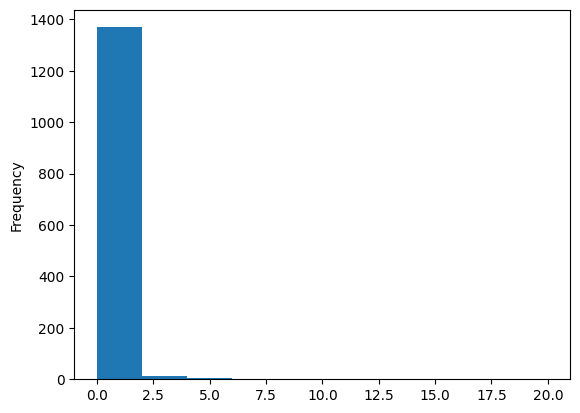

In [31]:
train_df.total_awards_received.plot.hist()

In [32]:
# Convert 'title' text into lists
train_titles = train_df["title"].tolist()
test_titles = test_df["title"].tolist()
len(train_titles), len(test_titles)

(1388, 347)

In [33]:
train_titles[:10]

['[OC] The only way to stop her from crawling into the front seat',
 'Saw this getting blood drawn today.',
 'It’s his cake day today, and He knew what was coming too.',
 'Sweetcorn lover🤗',
 'Bella Hadid Getting Emotional For Not Having Any Designer Items',
 "I'm convinced my phone (s22 ultra) is defective, here's just a small collection of the autocorrect doing more harm than good",
 "It's been two weeks of construction on my street, right in front of my house. Apparently it might end in September, or 2024. And yeah, that's a portapotty on my front lawn. Guess I have a new bathroom.",
 'nom :3',
 'Make way!!!',
 'Fine line between love and hate']

### Make Numeric Labels

Need to turn text into numerical format; looks like one hot encoding and label encoding does the job

#### One Hot Encode labels

Resource: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [34]:
# One hot encode the 'subreddit' labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["subreddit"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["subreddit"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Label Encode labels

Resource: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [35]:
# Label encode 'subreddit' labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["subreddit"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["subreddit"].to_numpy())
train_labels_encoded

array([1, 8, 1, ..., 1, 1, 5])

In [36]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(10,
 array(['Python', 'aww', 'cats', 'facepalm', 'gaming', 'memes',
        'mildlyinfuriating', 'news', 'oddlyspecific',
        'technicallythetruth'], dtype=object))

## Modeling

### Model 0: The Baseline

The baseline model will use the TF-IDF (term frequency-inverse document frequency) Multinomial Niave Bayes.  

Create a Scikit-Learn `Pipeline` using:  
* Use the `TfidVectorizer` class from Scikit-Learn to convert text data into numbers.  
* Use the `MultinomialNB` algorithm for classification learning.

Resources:
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [37]:
# Create the pipeline
model_base = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_base.fit(X=train_titles,
               y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

#### Evaluation

In [38]:
# Evaluate the baseline model on the test dataset
model_base.score(X=test_titles,
                 y=test_labels_encoded)

0.5504322766570605

In [39]:
# Make some predictions
baseline_predict = model_base.predict(test_titles)
baseline_predict

array([4, 0, 6, 6, 8, 1, 1, 4, 2, 7, 5, 2, 5, 4, 5, 1, 4, 6, 5, 0, 4, 2,
       7, 5, 0, 6, 1, 1, 6, 1, 1, 4, 7, 2, 1, 1, 6, 6, 0, 2, 2, 1, 4, 6,
       6, 6, 4, 6, 6, 5, 1, 2, 6, 1, 6, 5, 7, 6, 2, 2, 5, 5, 4, 4, 1, 5,
       6, 6, 1, 4, 3, 7, 3, 5, 7, 4, 6, 3, 4, 4, 2, 6, 4, 6, 6, 1, 2, 6,
       1, 2, 5, 4, 9, 7, 3, 6, 3, 1, 5, 5, 6, 3, 3, 3, 2, 6, 2, 5, 3, 3,
       1, 6, 6, 1, 3, 4, 3, 3, 6, 1, 4, 4, 6, 6, 7, 1, 4, 3, 1, 2, 7, 1,
       5, 3, 6, 4, 7, 3, 6, 2, 2, 7, 4, 5, 3, 7, 6, 5, 4, 6, 8, 4, 7, 4,
       1, 5, 4, 1, 5, 4, 4, 6, 2, 3, 2, 0, 2, 5, 3, 4, 6, 6, 9, 6, 6, 6,
       5, 2, 6, 5, 7, 1, 4, 6, 1, 9, 8, 2, 0, 0, 3, 0, 1, 6, 1, 6, 7, 1,
       4, 4, 9, 5, 9, 1, 2, 4, 6, 3, 5, 2, 6, 0, 5, 1, 3, 1, 4, 4, 6, 5,
       2, 5, 4, 6, 4, 2, 6, 7, 0, 4, 3, 6, 6, 1, 3, 6, 4, 7, 2, 6, 6, 6,
       1, 2, 6, 6, 6, 1, 1, 6, 0, 9, 6, 4, 4, 6, 4, 2, 4, 7, 1, 5, 6, 0,
       6, 2, 6, 5, 7, 4, 6, 9, 2, 4, 6, 1, 7, 9, 6, 7, 6, 2, 7, 3, 5, 5,
       3, 7, 1, 5, 4, 6, 6, 3, 6, 5, 4, 6, 5, 4, 6,

The `baseline_predict` array contains integers that correlate to the label (subreddit).  

E.g. '0' correlates to 'r/python' and '8' correlates to 'r/news'.  

The maximum integer is determined by the number of unique subreddit labels in the dataset.

In [40]:
# Calculate baseline model accuracy
baseline_accuracy = accuracy_score(y_true=test_labels_encoded,
                                y_pred=baseline_predict)

In [41]:
# Calculate baseline model precision, recall, and f1 score using weighted average
baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(y_true=test_labels_encoded,
                                                                              y_pred=baseline_predict,
                                                                              average="weighted")

In [42]:
# Display mbaseline model results
baseline_results = {"accuracy": baseline_accuracy,
                    "precision": baseline_precision,
                    "recall": baseline_recall,
                    "f1": baseline_f1}
baseline_results

{'accuracy': 0.5504322766570605,
 'precision': 0.6544954168841474,
 'recall': 0.5504322766570605,
 'f1': 0.5510624734145613}

As of the last time the code above was executed: accuracy, precision, recall, and f1 scores are near 50%.  

Not sure if the baseline is performing poorly because of the data itself, the train-to-test ratio, or the model is not optimal for this 
project.  

Need to make build more models and evaluate their performances to compare.

### Intermission: Preparing data for TensorFlow Models

Before building the model, first do a couple things with the data
1. Create a vectorization layer - converts text to numbers
2. Create an embedding layer - captures the relationships between the vectorized numbers

First, find out how many words are in each post.  

The goal is to add padding (zeros) to vectors such that each 'title' post is the same length in the vectorizer.  

E.g. A random 'title' is 5 words long and the longest 'title' contains 20 words, which means the 5-word 'title' will be padded with zeros so that it ends up being the same length as the 20-word 'title'.

In [43]:
# What is the average length of each 'title'?
title_lens = [len(sentence.split()) for sentence in train_titles]
avg_title_len = np.mean(title_lens)
avg_title_len

8.87463976945245

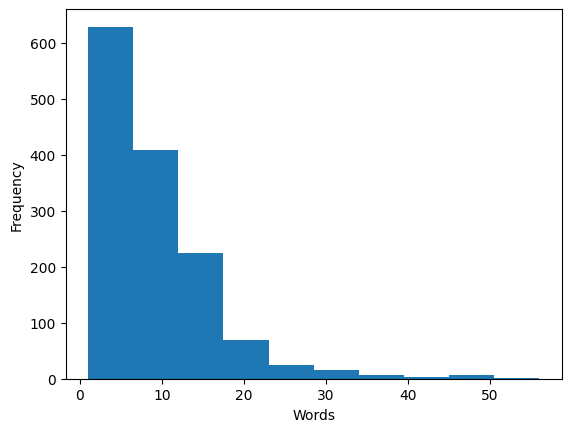

In [44]:
# What is the distribution for 'title' length?
plt.hist(title_lens)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [45]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(title_lens, 95))
output_seq_len

21

According to the histogram and percentile function, 95% of the 'title' data in the training dataset has a length of `output_seq_len` or less.  

So, 'title' data during vectorization should be `output_seq_len` long; the data is padded if shorter than `output_seq_len` or is truncated if longer than `output_seq_len`.

It is better to set `output_seq_len` to the 95% percentile rather than the maximum because the histogram shows most 'title' data is under 20 words long.  

Using the maximum value for `output_seq_len` would result in anunecessary amount of padding to the vectorized data.

#### Create the Text Vectorizer using TensorFlow

In [46]:
# how many words are on the vocabulary?
max_tokens = df.title.nunique()
max_tokens

1386

Use the TensorFlow `TextVectorization` function with `output_seq_len` and `max_tokens` as parameters.

Adapt the TensorFlow text vectorizer to the training 'title' data

Resource: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [47]:
# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

# Adapt text vectorizer to training data
text_vectorizer.adapt(train_titles)

In [48]:
# Test the text vectorizer on random samples from dataset
random_title = random.choice(train_titles)
print(f"Text:\n{random_title}")
print(f"\nLength of text: {len(random_title.split())}")
print(f"\nVectorized text:\n{text_vectorizer([random_title])}")

Text:
Kicked off his NFL team, lost his multi million dollar contract. Name dragged through the mud. And wasn’t even there. All based on what someone SAID.

Length of text: 26

Vectorized text:
[[1231  165   55 1141  158  235   55 1157  463    1    1  166    1  267
     2 1158    9  556   76  269   45]]


In [49]:
# What does the config of the text vectorizer look like?
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 1386,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 21,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 1386}

In [50]:
# How many words are in the text vectorizer's vocabulary?
# What are the most/least common words in the vocabulary?
text_vec_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(text_vec_vocab)}")
print(f"Most common words in vocabulary {text_vec_vocab[:5]}")
print(f"Least common words in vocabulary {text_vec_vocab[-5:]}")

Number of words in vocabulary: 1386
Most common words in vocabulary ['', '[UNK]', 'the', 'a', 'to']
Least common words in vocabulary ['edit', 'eaten', 'ease', 'dying', 'dungeon']


#### Creating Text Embeddings using TensorFlow

The embedding layer takes in integer inputs of the `text_vectorizer` layer and converts the integers into feature vectors of size `output_dim`.  

Start off with token embeddings, which looks at the relationship between sequences of words

In [51]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(text_vec_vocab),
                               output_dim=128, # I chose a common output dimension that is a power of 2
                               mask_zero=True,
                               name="token_embedding")

In [52]:
print(f"Title before vectorization:\n{random_title}\n")
vectorized_title = text_vectorizer([random_title])

Title before vectorization:
Kicked off his NFL team, lost his multi million dollar contract. Name dragged through the mud. And wasn’t even there. All based on what someone SAID.



In [53]:
print(f"Title after vectorization (before embedding):\n{vectorized_title}\n")
embedded_title = token_embed(vectorized_title)

Title after vectorization (before embedding):
[[1231  165   55 1141  158  235   55 1157  463    1    1  166    1  267
     2 1158    9  556   76  269   45]]



In [54]:
print(f"Sentence after embedding:\n{embedded_title}\n")
print(f"Embedded sentence shape: {embedded_title.shape}")

Sentence after embedding:
[[[ 0.03356233 -0.0186103   0.03621718 ... -0.03330532  0.00454511
   -0.00103072]
  [-0.02985975  0.03007022  0.01084147 ... -0.01935346 -0.03075277
    0.02076098]
  [ 0.04645817  0.00092475  0.04193524 ...  0.03973294 -0.00594383
   -0.03547595]
  ...
  [ 0.03223742 -0.0147608   0.02896776 ... -0.00480806 -0.01061317
    0.04343288]
  [-0.00255126 -0.02831504 -0.03050829 ... -0.00985948 -0.01922451
   -0.01773368]
  [ 0.02426399  0.04393869  0.04325428 ...  0.00673834 -0.00394667
   -0.02934915]]]

Embedded sentence shape: (1, 21, 128)


#### Data Batching

Use the `tf.data` API to turn data into TensorFlow datasets and prefetched batches for more optimal training

Resource: https://www.tensorflow.org/guide/data

In [55]:
# Produce TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_titles, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_titles, test_labels_one_hot))

# Turn the TensorSliceDatasets into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>)

### Model 1: Conv1D with Token Embeddings

Create a 1D Convolutional Neural Network model

Resources:
* https://www.tensorflow.org/guide/keras/functional
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
* https://www.tensorflow.org/api_docs/python/tf/keras/Model
* https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

#### Building

In [56]:
# Create model architecture
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [57]:
# Summary of the layers and hyperparameters of the model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 21)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 21, 128)          177408    
                                                                 
 conv1d (Conv1D)             (None, 21, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                650   

Interesting things about the summary:
* The shapes for the token embedding and text vectoriation in the summary should match what was recorded earlier in the notebook.
* The Conv1D layer reduced the shape of the data in half
* The global avreage pooling layer flattened the dimensions from the Conv1D layer
* The final output layer should be the same shape as the number of unique 'subreddit' labels in the dataset.
* Only the embedding layer, conv1D layer, and the dense layer had trainable hyperparameters; the weights of only these layers are updated during training

In [58]:
# Compile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

#### Training

In [59]:
# Fit the training dataset to the model
model_1_history = model_1.fit(train_dataset,
                              epochs=50,
                              validation_data=test_dataset,
                              verbose=1)

Epoch 1/50
44/44 [==============================] - 1s 7ms/step - loss: 2.2779 - accuracy: 0.1318 - val_loss: 2.2343 - val_accuracy: 0.1412
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 2.1638 - accuracy: 0.2068 - val_loss: 2.1376 - val_accuracy: 0.2738
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 1.9665 - accuracy: 0.3775 - val_loss: 1.9538 - val_accuracy: 0.3487
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 1.6655 - accuracy: 0.5086 - val_loss: 1.7488 - val_accuracy: 0.4150
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 1.3803 - accuracy: 0.5749 - val_loss: 1.6182 - val_accuracy: 0.4611
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 1.1622 - accuracy: 0.6491 - val_loss: 1.5190 - val_accuracy: 0.4957
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 0.9945 - accuracy: 0.7140 - val_loss: 1.4490 - val_accuracy: 0.5331
Epoch 8/50
44/44 [==

#### Evaluating

In [60]:
# Evalute on the test dataset
model_1.evaluate(test_dataset)

11/11 [==============================] - 0s 2ms/step - loss: 2.9374 - accuracy: 0.5648


[2.937387466430664, 0.5648415088653564]

Based on the last time the model was trained, the evaluation validation loss is very high and the validation accuracy is around 55%. 

However, the training loss was very low and the training accuracy was very high.  

It is reasonable to say that the model is overfitting to the training data, and performs poorly on unseen data.

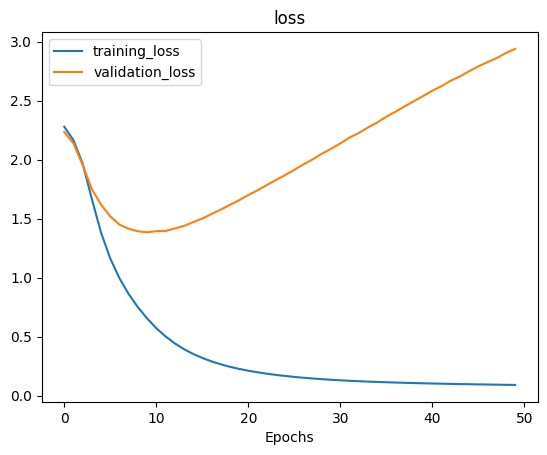

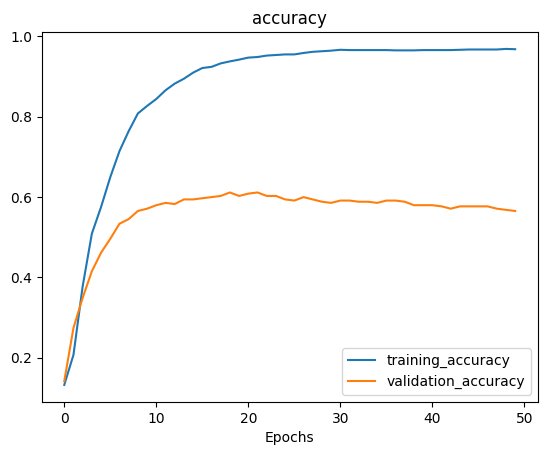

In [61]:
# Plot the loss and accuracy curves
loss = model_1_history.history['loss']
val_loss = model_1_history.history['val_loss']
accuracy = model_1_history.history['accuracy']
val_accuracy = model_1_history.history['val_accuracy']
epochs = range(len(model_1_history.history['loss']))

plt.figure()
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='validation_loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='validation_accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Looks like overfitting to me.

Make predictions on the test dataset anyway.

In [62]:
# Make predictions (output should be a matrix of prediction probabilities)
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs.shape, model_1_pred_probs

11/11 [==============================] - 0s 1ms/step


((347, 10),
 array([[2.66154238e-05, 3.55981697e-08, 1.51932963e-05, ...,
         2.46732111e-06, 6.08396988e-07, 1.21132680e-05],
        [1.05986623e-02, 6.66329882e-12, 1.06937925e-08, ...,
         8.83885860e-01, 6.52712950e-09, 1.36755274e-09],
        [7.94409588e-03, 2.71541940e-04, 9.05438501e-04, ...,
         1.21606570e-02, 1.96781471e-01, 8.00804410e-04],
        ...,
        [3.96551788e-02, 3.03923292e-03, 5.50794482e-01, ...,
         7.54346956e-06, 3.75164200e-05, 8.51108343e-04],
        [1.72944652e-04, 6.89601948e-05, 9.67277856e-07, ...,
         7.79422606e-08, 2.76737028e-05, 9.97265339e-01],
        [7.26329954e-03, 1.09623866e-02, 3.30697000e-03, ...,
         4.53879498e-02, 1.64307430e-01, 3.27000604e-03]], dtype=float32))

In [63]:
# Convert the prediction probabilities to labels
model_1_predictions = tf.argmax(model_1_pred_probs, axis=1)
model_1_predictions

<tf.Tensor: shape=(347,), dtype=int64, numpy=
array([4, 7, 6, 2, 2, 2, 1, 4, 2, 7, 9, 2, 7, 4, 9, 2, 4, 0, 5, 0, 4, 5,
       6, 2, 2, 6, 1, 1, 3, 1, 1, 4, 7, 2, 5, 1, 5, 6, 0, 5, 2, 1, 4, 2,
       2, 6, 1, 5, 1, 5, 1, 2, 1, 1, 5, 5, 7, 3, 2, 2, 5, 8, 4, 4, 1, 8,
       6, 5, 1, 7, 3, 7, 9, 5, 7, 4, 6, 2, 4, 6, 5, 6, 9, 6, 6, 1, 2, 9,
       2, 2, 5, 4, 1, 7, 3, 2, 3, 2, 5, 5, 4, 8, 4, 3, 0, 6, 5, 8, 3, 3,
       1, 5, 9, 2, 9, 4, 2, 3, 1, 1, 4, 4, 6, 1, 7, 1, 1, 3, 2, 4, 7, 1,
       1, 2, 6, 4, 7, 3, 6, 2, 2, 7, 4, 5, 9, 7, 6, 5, 4, 6, 8, 4, 3, 4,
       1, 0, 4, 2, 8, 4, 4, 6, 2, 3, 2, 0, 2, 5, 9, 4, 6, 5, 9, 2, 2, 2,
       5, 5, 5, 5, 7, 1, 4, 8, 8, 9, 8, 9, 0, 0, 3, 0, 1, 6, 5, 2, 7, 9,
       2, 4, 4, 4, 9, 7, 2, 4, 2, 3, 5, 2, 6, 0, 9, 1, 3, 1, 3, 2, 8, 5,
       8, 5, 8, 6, 6, 2, 2, 7, 0, 4, 3, 7, 6, 1, 3, 2, 4, 7, 2, 5, 2, 6,
       1, 2, 3, 3, 6, 1, 1, 9, 0, 9, 6, 4, 4, 5, 2, 2, 4, 7, 2, 9, 2, 0,
       9, 1, 6, 0, 7, 4, 6, 9, 2, 5, 2, 1, 7, 9, 6, 7, 5, 6, 7, 3, 5, 3,
     

Cool, `model_1_predictions` is a list containing the predicted integer corresponding to a specific 'subreddit' label.

Despite poor performance of the model, still observe the predicted labels with their true labels.

Use the `label_encoder.classes_` function to map predictions to test dataframe.

In [64]:
copy_df = test_df.copy()
copy_df["predicted_subreddit"] = [label_encoder.classes_[pred] for pred in model_1_predictions]
copy_df["correct_prediction"] = copy_df["subreddit"] == copy_df["predicted_subreddit"]
copy_df.head()

,subreddit,title,upvote_ratio,score,total_awards_received,predicted_subreddit,correct_prediction
625,gaming,Favorite game studio?,0.67,2.0,0.0,gaming,True
14,Python,Test On 4 Concurrent Jobs Using Python-Polars ...,0.83,33.0,0.0,news,False
165,mildlyinfuriating,This one bagel bite,0.83,22.0,0.0,mildlyinfuriating,True
618,gaming,Skygerfall,0.60,1.0,0.0,cats,False
1640,oddlyspecific,MBA Rankings,0.75,2.0,0.0,cats,False


In [65]:
# Get how many predictions were correct for the test dataset
copy_df.correct_prediction.value_counts()

correct_prediction
True     196
False    151
Name: count, dtype: int64

Similar to the baseline mdoe, calculate scores for the Conv1D model: accuracy, precision, recall, f1.

But functionalize so it can be used repeatedly for future models.

In [66]:
# function returns a dictionary of the scores
def calculate_scores(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_scores = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_scores

In [67]:
model_1_scores = calculate_scores(y_true=test_labels_encoded,
                                  y_pred=model_1_predictions)
model_1_scores

{'accuracy': 0.5648414985590778,
 'precision': 0.5988538274675087,
 'recall': 0.5648414985590778,
 'f1': 0.5738988260659642}

## Model 2: Conv1D using Character Embeddings

Instead of creating an embedding based on a sequence of words, create an embedding based on the sequence/position of characters in words

#### Preprocessing

In [68]:
# Split 'title' text into characters
train_chars = [" ".join(list(sentence)) for sentence in train_titles]
test_chars = [" ".join(list(sentence)) for sentence in test_titles]
print(train_chars[0])

[ O C ]   T h e   o n l y   w a y   t o   s t o p   h e r   f r o m   c r a w l i n g   i n t o   t h e   f r o n t   s e a t


In [69]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_titles]
mean_char_len = np.mean(char_lens)
mean_char_len

49.226945244956774

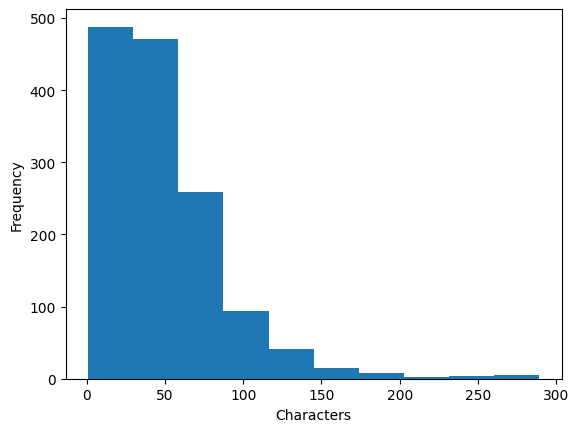

In [70]:
# What does the distribution of char-level sequences look like?
plt.hist(char_lens)
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

In [71]:
# What is the 95 percentile of teh character-level sequences?
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

119

Note: the `max_tokens` should be the length of the alphabet (26) + space (1) + unkown/not in vocab (1) = 28

In [72]:
# Get all keyboard characters for character-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [73]:
# Create char-level token vectorizer
char_vectorizer = TextVectorization(max_tokens=len(alphabet)+2,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [74]:
# Adapt the vectorizer to the training characters
char_vectorizer.adapt(train_chars)

In [75]:
# How many unqiue characters are in the vectorizer; what are the most/least common characters
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"Most common characters: {char_vocab[:5]}")
print(f"Least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
Most common characters: ['', '[UNK]', 'e', 't', 'a']
Least common characters: ['🤷', '🤭', '🤦', '🤣', '🤗']


In [76]:
# Test the character vectorizer on a random sample from training dataset
random_train_chars = random.choice(train_chars)
print(f"Char text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Char text:
I t ' s   l e a v e   y o u r   h o t   d o g   i n   t h e   c a r   s e a s o n

Length of chars: 33

Vectorized chars:
[[ 6  3  7 11  2  4 23  2 17  5 15  9 10  5  3 12  5 16  6  8  3 10  2 13
   4  9  7  2  4  7  5  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Length of vectorized chars: 119


In [77]:
# batch the datasets for training
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset, test_char_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>)

#### Building

In [78]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(alphabet)+2,
                              output_dim=32, # again I chose a power of 2
                              mask_zero=False,
                              name="char_embed")

# Test the character embedding layer on training dataset
print(f"Char text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Char embedding shape: {char_embed_example.shape}")

Char text (before vectorization and embedding):
I t ' s   l e a v e   y o u r   h o t   d o g   i n   t h e   c a r   s e a s o n

Chars (after vectorization and embedding):
[[[ 0.03817792  0.03146679  0.03372219 ... -0.01692575 -0.01030693
    0.02588946]
  [-0.03200497  0.02256924  0.02425997 ... -0.03329492 -0.01820414
   -0.04250437]
  [ 0.02013483  0.04577983 -0.00269084 ... -0.01471909 -0.03010082
   -0.02349477]
  ...
  [ 0.00757438 -0.04394364 -0.01574788 ... -0.02304238 -0.04788145
    0.03575804]
  [ 0.00757438 -0.04394364 -0.01574788 ... -0.02304238 -0.04788145
    0.03575804]
  [ 0.00757438 -0.04394364 -0.01574788 ... -0.02304238 -0.04788145
    0.03575804]]]

Char embedding shape: (1, 119, 32)


In [79]:
# Make another Conv1D model but using the char vectorized layer and embedding layer
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(inputs)
char_embeddings = char_embed(char_vector)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_conv1D_char_embeddings")

In [80]:
# Summary of model 2
model_2.summary()

Model: "model_2_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 119)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 119, 32)           2240      
                                                                 
 conv1d_1 (Conv1D)           (None, 119, 64)           10304     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 

In [81]:
# Compile
model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Training

In [82]:
# Fit the model using the prefetched char-only dataset
model_2_history = model_2.fit(train_char_dataset,
                              epochs=50,
                              validation_data=test_char_dataset,
                              verbose=1)

Epoch 1/50
44/44 [==============================] - 1s 6ms/step - loss: 2.2909 - accuracy: 0.1189 - val_loss: 2.2852 - val_accuracy: 0.1527
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 2.2616 - accuracy: 0.2075 - val_loss: 2.2675 - val_accuracy: 0.1758
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 2.2321 - accuracy: 0.2471 - val_loss: 2.2384 - val_accuracy: 0.1758
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 2.1868 - accuracy: 0.2644 - val_loss: 2.1918 - val_accuracy: 0.2046
Epoch 5/50
44/44 [==============================] - 0s 3ms/step - loss: 2.1173 - accuracy: 0.3019 - val_loss: 2.1270 - val_accuracy: 0.2536
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 2.0228 - accuracy: 0.3581 - val_loss: 2.0541 - val_accuracy: 0.2968
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 1.9145 - accuracy: 0.3919 - val_loss: 1.9839 - val_accuracy: 0.3429
Epoch 8/50
44/44 [==

#### Evaluating

In [83]:
# Evaluate the model on the test char dataset
model_2.evaluate(test_char_dataset)

11/11 [==============================] - 0s 1ms/step - loss: 2.0313 - accuracy: 0.5533


[2.0312583446502686, 0.5533141493797302]

In [84]:
# Create a function to plot the loss and accuracy curves for future models
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

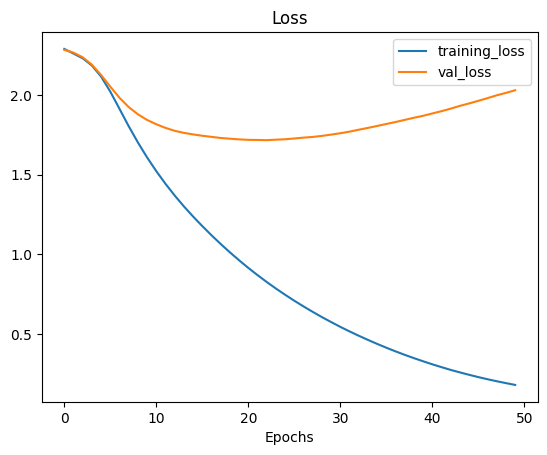

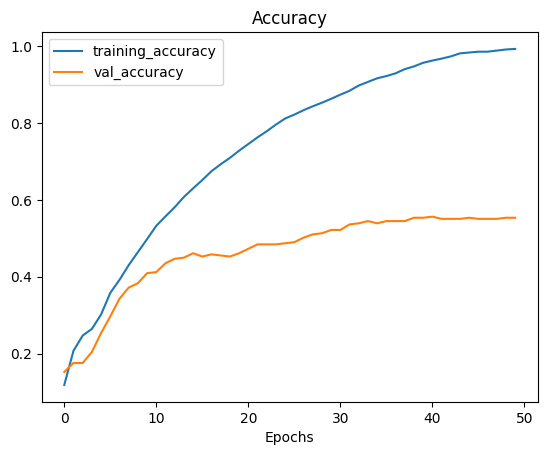

In [85]:
# Plot the loss and accuracy curves for model 2
plot_loss_curves(history=model_2_history)

In [86]:
# Make predictions with the char model
model_2_pred_probs = model_2.predict(test_char_dataset)
model_2_pred_probs.shape, model_2_pred_probs

11/11 [==============================] - 0s 1ms/step


((347, 10),
 array([[2.1006802e-10, 4.6952377e-07, 1.2602336e-06, ..., 1.6876358e-09,
         5.7341444e-04, 4.2648358e-06],
        [9.9722481e-01, 4.4290526e-04, 6.9965836e-06, ..., 1.7614261e-04,
         2.4495419e-05, 1.6544969e-04],
        [2.9432817e-04, 6.8427287e-02, 2.9401539e-02, ..., 1.3774361e-06,
         3.9122462e-01, 1.2756872e-01],
        ...,
        [5.0618645e-02, 4.2384733e-02, 1.1407195e-03, ..., 9.5719278e-02,
         3.1480901e-02, 7.5152988e-05],
        [1.1494972e-03, 5.1164487e-05, 8.5945503e-04, ..., 5.1586783e-01,
         1.8576777e-02, 3.1853110e-02],
        [1.6795250e-03, 1.6420372e-01, 4.1092899e-02, ..., 8.3282626e-05,
         7.9281688e-02, 3.7150551e-02]], dtype=float32))

In [87]:
# Convert prediction porbabilities to integers that represent 'subreddit' labels
model_2_predictions = tf.argmax(model_2_pred_probs, axis=1)
model_2_predictions

<tf.Tensor: shape=(347,), dtype=int64, numpy=
array([4, 0, 8, 1, 8, 3, 1, 4, 8, 7, 9, 2, 7, 4, 6, 5, 4, 8, 5, 6, 4, 2,
       0, 3, 0, 7, 1, 1, 9, 1, 1, 4, 7, 1, 5, 1, 3, 7, 0, 6, 2, 1, 4, 6,
       9, 2, 5, 1, 7, 5, 1, 2, 3, 1, 0, 4, 7, 6, 2, 7, 9, 0, 4, 4, 1, 0,
       3, 6, 1, 4, 9, 7, 9, 3, 7, 4, 5, 3, 4, 6, 6, 2, 6, 6, 2, 1, 7, 5,
       1, 2, 3, 6, 9, 7, 3, 4, 3, 2, 2, 5, 8, 1, 3, 3, 7, 4, 6, 8, 3, 3,
       1, 6, 9, 2, 9, 4, 8, 3, 6, 8, 4, 4, 6, 9, 7, 1, 5, 3, 1, 2, 7, 1,
       5, 3, 1, 4, 7, 3, 9, 6, 2, 7, 4, 5, 9, 7, 0, 5, 4, 8, 8, 4, 6, 4,
       4, 2, 4, 5, 2, 4, 4, 6, 2, 3, 2, 0, 3, 4, 3, 4, 7, 8, 9, 7, 1, 3,
       9, 3, 3, 4, 7, 1, 4, 8, 8, 5, 8, 2, 0, 0, 7, 0, 1, 7, 9, 7, 7, 9,
       4, 4, 3, 5, 9, 7, 0, 0, 2, 3, 5, 9, 1, 0, 6, 1, 3, 1, 3, 1, 5, 9,
       8, 9, 6, 6, 7, 2, 6, 7, 0, 7, 3, 7, 1, 1, 1, 7, 9, 7, 1, 8, 4, 7,
       1, 2, 3, 3, 5, 1, 6, 7, 0, 9, 5, 0, 4, 0, 2, 3, 4, 7, 6, 1, 0, 0,
       0, 1, 6, 9, 7, 4, 3, 9, 2, 4, 6, 1, 7, 9, 6, 7, 9, 1, 7, 9, 0, 5,
     

In [88]:
# compare the 'subreddit' predictions with the true 'subreddit' labels
copy_df = test_df.copy()
copy_df["predicted_subreddit"] = [label_encoder.classes_[pred] for pred in model_1_predictions]
copy_df["correct_prediction"] = copy_df["subreddit"] == copy_df["predicted_subreddit"]
copy_df.head()

,subreddit,title,upvote_ratio,score,total_awards_received,predicted_subreddit,correct_prediction
625,gaming,Favorite game studio?,0.67,2.0,0.0,gaming,True
14,Python,Test On 4 Concurrent Jobs Using Python-Polars ...,0.83,33.0,0.0,news,False
165,mildlyinfuriating,This one bagel bite,0.83,22.0,0.0,mildlyinfuriating,True
618,gaming,Skygerfall,0.60,1.0,0.0,cats,False
1640,oddlyspecific,MBA Rankings,0.75,2.0,0.0,cats,False


In [89]:
# How many predictions were wrong and how many were correct?
copy_df.correct_prediction.value_counts()

correct_prediction
True     196
False    151
Name: count, dtype: int64

In [90]:
# Get the scores for model 2
model_2_scores = calculate_scores(y_true=test_labels_encoded,
                                  y_pred=model_2_predictions)
model_2_scores

{'accuracy': 0.553314121037464,
 'precision': 0.5495980189019302,
 'recall': 0.553314121037464,
 'f1': 0.543430296991778}

In [91]:
# Model 1 Scores?
model_1_scores

{'accuracy': 0.5648414985590778,
 'precision': 0.5988538274675087,
 'recall': 0.5648414985590778,
 'f1': 0.5738988260659642}

Nice, looks like model 2 performed better than model 1, but not by much. It is, however, still an improvement

### Model 3: Feature Extraction with Token Embeddings and Character Embeddings

Use Transfer learning from `TensorFlow Hub` to train model 3 while incorporating both token and character embeddings.

Feature Extraction using pretrained `Universal Sentence Encoder (USE)` from TensorFlow Hub for token embeddings.

Resources:
* https://tfhub.dev/google/universal-sentence-encoder/4
* https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer

In [92]:
# Download USE from TensorFlow Hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="USE")

In [93]:
# Does it work? Test it out on a random subreddit title
random_sentence = random.choice(train_titles)
print(f"Random subreddit title:\n{random_sentence}\n")
use_sentence = tf_hub_embedding_layer([random_sentence])
print(f"USE Embedded sentence:\n{use_sentence[0]}\n")
print(f"Length of embedded sentence:\n{len(use_sentence[0])}")

Random subreddit title:
Stairway To The Attic

USE Embedded sentence:
[ 3.55501994e-02  5.81026860e-02  8.24567005e-02 -2.22534165e-02
  1.69850443e-03 -4.28671613e-02  1.00660268e-02  2.67645288e-02
  7.51857704e-04  3.62988934e-02  3.94761637e-02 -6.20084181e-02
 -3.38820107e-02  2.49225814e-02 -1.30703980e-02  3.90565395e-02
 -5.99289648e-02  2.90720686e-02  2.10412834e-02 -6.85259923e-02
 -3.39461938e-02  6.55752942e-02 -5.53245544e-02 -2.22192761e-02
 -8.00301582e-02  5.37161306e-02  3.17322724e-02 -4.86946627e-02
  1.70329725e-03  2.55551860e-02  5.55201899e-03 -4.94765379e-02
 -2.02721506e-02  6.79371580e-02 -1.41620133e-02  4.78201769e-02
 -5.91822900e-03  6.68368861e-02  1.58185270e-02  6.43517971e-02
  6.69852272e-02 -3.56505252e-02 -7.39517808e-02 -4.11879010e-02
 -6.14863597e-02 -2.87378635e-02 -5.33205308e-02 -2.45878212e-02
  4.89284173e-02 -5.02037117e-03  5.71053773e-02 -2.95643765e-03
  4.30283062e-02 -1.25545105e-02  7.93884844e-02 -7.57251009e-02
  3.70306484e-02 -1.

#### Combine the token and character data into a prefetched dataset with batch size 32

Resources: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [94]:
# Combine the token and character datasets
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_titles, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_token_char_data = tf.data.Dataset.from_tensor_slices((test_titles, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_token_char_dataset, test_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>)

#### Building

Build the model that will incorporate the USE pretrained embedding layer and the token and character sequence data.

In [95]:
# 1. Make the model for token embeddings using the USE pretained token embedding layer
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

The character model is the same architecture as model 2 except the `Conv1D` and `GlobalMaxPooling1D` layers.  

Instead of a CNN, the mdoel uses an RNN, specifically a bidirectional LSTM.  

The supposed advantages of an the Bidirectional LSTM over a CNN is that:
* information about the sequences can flow in both directions (forward and back)
* better suited for temporal data or sequential data (things with order)
* Convolutions are better suited for spatial data, like images (not ideal for this dataset)

Resource: https://www.springboard.com/blog/data-science/rnn-vs-cnn/

In [96]:
# 2. Make the mdoel for character embeddings
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
char_outputs = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_outputs)

Concatenate token and character models using the `Concatentate()` layer.   
Resource: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate

In [97]:
# 3. Combine the token and character inputs
token_char = layers.Concatenate(name="token_char")([token_model.output,
                                                    char_model.output])

To help prevent overfitting, drop a fraction of the data in the model during training using the `Dropout()` layer.  
Resource: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

In [98]:
# 4. Build the output layers 
x = layers.Dropout(0.5)(token_char)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [99]:
# 5. Stitch everything together
model_3 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output,
                         name="model_3_token_char_hybrid")

In [100]:
# What does the summary look like?
model_3.summary()

Model: "model_3_token_char_hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 119)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_i

In [101]:
print("layer name\ttrainable\n")
for layer in model_3.layers:
    print(f"{layer.name}:\t{layer.trainable}")

layer name	trainable

char_input:	True
token_input:	True
char_vectorizer:	True
USE:	False
char_embed:	True
dense_2:	True
bidirectional:	True
token_char:	True
dropout:	True
dense_3:	True
dropout_1:	True
dense_4:	True


Looks like there are some hyperparameters that are not trainable, which come from the USE pretained token embedding layer from TensorFlow Hub.

In [102]:
# Compile the model
model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Training

In [103]:
# Fit the model
model_3_history = model_3.fit(train_token_char_dataset,
                              epochs=10,
                              validation_data=test_token_char_dataset,
                              verbose=1)

Epoch 1/10
44/44 [==============================] - 5s 38ms/step - loss: 2.2732 - accuracy: 0.1499 - val_loss: 2.2084 - val_accuracy: 0.2911
Epoch 2/10
44/44 [==============================] - 1s 21ms/step - loss: 2.0915 - accuracy: 0.3127 - val_loss: 1.8422 - val_accuracy: 0.5533
Epoch 3/10
44/44 [==============================] - 1s 21ms/step - loss: 1.6336 - accuracy: 0.4705 - val_loss: 1.2873 - val_accuracy: 0.5937
Epoch 4/10
44/44 [==============================] - 1s 21ms/step - loss: 1.3104 - accuracy: 0.5418 - val_loss: 1.1053 - val_accuracy: 0.6340
Epoch 5/10
44/44 [==============================] - 1s 21ms/step - loss: 1.1442 - accuracy: 0.6095 - val_loss: 1.0394 - val_accuracy: 0.6340
Epoch 6/10
44/44 [==============================] - 1s 21ms/step - loss: 1.0244 - accuracy: 0.6434 - val_loss: 1.0018 - val_accuracy: 0.6311
Epoch 7/10
44/44 [==============================] - 1s 22ms/step - loss: 0.9475 - accuracy: 0.6859 - val_loss: 0.9836 - val_accuracy: 0.6369
Epoch 8/10
44

#### Evaluating

In [104]:
# Evaluate
model_3.evaluate(test_token_char_dataset)

11/11 [==============================] - 0s 8ms/step - loss: 0.9673 - accuracy: 0.6715


[0.9673064351081848, 0.6714697480201721]

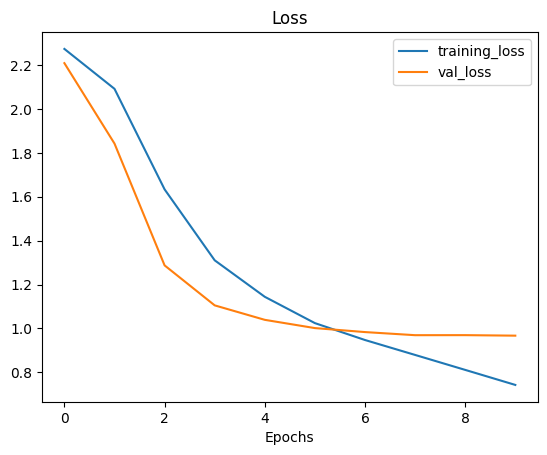

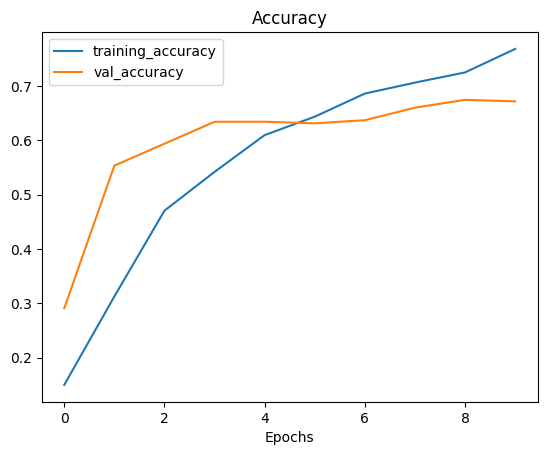

In [105]:
# Plot the loss and accuracy curves
plot_loss_curves(history=model_3_history)

WOW... Improvements!!!

Now get the prediction probabilities of the test dataset and check the model evaluation scores

In [106]:
# get the prediction probabilities of the token-character hybrid model
model_3_pred_probs = model_3.predict(test_token_char_dataset)
model_3_pred_probs.shape, model_3_pred_probs

11/11 [==============================] - 1s 7ms/step


((347, 10),
 array([[1.7252275e-04, 1.0335208e-05, 1.9677731e-05, ..., 9.9525796e-06,
         2.8783616e-05, 4.5969075e-05],
        [9.8943955e-01, 3.2320796e-04, 1.7452548e-04, ..., 1.6719610e-03,
         3.4517545e-04, 1.1449400e-03],
        [4.5908138e-05, 7.2269171e-02, 2.2129618e-02, ..., 2.8511303e-04,
         3.9088823e-02, 3.1348129e-03],
        ...,
        [6.5212729e-03, 4.7183621e-01, 1.8383753e-01, ..., 7.5921388e-03,
         7.0269890e-02, 4.9565997e-02],
        [3.1132731e-03, 3.9778911e-02, 5.0137531e-02, ..., 1.9453913e-03,
         3.4429604e-01, 1.7683472e-01],
        [2.6088471e-03, 9.3800843e-02, 3.4010600e-02, ..., 1.0024485e-02,
         7.9320550e-02, 1.0091180e-01]], dtype=float32))

In [107]:
# Turn the prediction probabilities into integers corresponding to a predicted 'subreddit' label
model_3_predictions = tf.argmax(model_3_pred_probs, axis=1)
model_3_predictions

<tf.Tensor: shape=(347,), dtype=int64, numpy=
array([4, 0, 6, 8, 2, 9, 1, 6, 1, 7, 3, 2, 7, 4, 9, 1, 4, 6, 9, 0, 4, 2,
       7, 2, 0, 6, 1, 1, 9, 1, 1, 4, 7, 1, 1, 1, 4, 3, 0, 3, 2, 1, 5, 3,
       3, 5, 3, 6, 6, 5, 1, 2, 3, 1, 4, 4, 7, 3, 2, 2, 4, 6, 4, 4, 1, 6,
       6, 6, 1, 4, 2, 7, 1, 7, 7, 4, 5, 3, 4, 5, 3, 6, 3, 6, 6, 1, 7, 5,
       1, 1, 7, 4, 5, 7, 3, 2, 3, 1, 5, 5, 6, 8, 0, 7, 3, 6, 3, 5, 3, 3,
       1, 6, 9, 2, 5, 4, 2, 3, 1, 2, 4, 4, 6, 2, 3, 1, 4, 3, 1, 1, 3, 1,
       9, 3, 6, 4, 7, 3, 6, 7, 2, 7, 4, 5, 1, 7, 0, 5, 4, 6, 8, 4, 7, 4,
       1, 5, 4, 2, 1, 4, 4, 6, 2, 3, 2, 0, 2, 4, 4, 4, 5, 5, 9, 3, 8, 3,
       6, 5, 4, 5, 7, 1, 4, 8, 3, 2, 8, 2, 0, 0, 3, 0, 1, 3, 1, 2, 7, 3,
       4, 4, 5, 2, 9, 7, 2, 0, 1, 3, 6, 2, 6, 0, 3, 1, 3, 1, 2, 8, 9, 3,
       2, 6, 6, 6, 5, 2, 9, 7, 0, 4, 3, 7, 5, 1, 3, 3, 4, 7, 2, 5, 2, 3,
       1, 2, 6, 3, 5, 4, 2, 8, 0, 9, 3, 3, 4, 4, 5, 2, 4, 7, 2, 3, 2, 0,
       9, 1, 4, 9, 7, 4, 3, 9, 2, 4, 2, 1, 7, 9, 6, 7, 5, 1, 7, 9, 6, 1,
     

In [108]:
# Get the scores of the token-character hybrid model
model_3_scores = calculate_scores(y_true=test_labels_encoded,
                                  y_pred=model_3_predictions)
model_3_scores

{'accuracy': 0.6714697406340058,
 'precision': 0.6713967365387397,
 'recall': 0.6714697406340058,
 'f1': 0.6603771944715509}

In [109]:
copy_df = test_df.copy()
copy_df["predicted_subreddit"] = [label_encoder.classes_[pred] for pred in model_1_predictions]
copy_df["correct_prediction"] = copy_df["subreddit"] == copy_df["predicted_subreddit"]
copy_df.head()

,subreddit,title,upvote_ratio,score,total_awards_received,predicted_subreddit,correct_prediction
625,gaming,Favorite game studio?,0.67,2.0,0.0,gaming,True
14,Python,Test On 4 Concurrent Jobs Using Python-Polars ...,0.83,33.0,0.0,news,False
165,mildlyinfuriating,This one bagel bite,0.83,22.0,0.0,mildlyinfuriating,True
618,gaming,Skygerfall,0.60,1.0,0.0,cats,False
1640,oddlyspecific,MBA Rankings,0.75,2.0,0.0,cats,False


In [110]:
# How many predictions were correct and wrong?
copy_df.correct_prediction.value_counts()

correct_prediction
True     196
False    151
Name: count, dtype: int64

### Comparing Model Results

In [111]:
# Compare the scores across all models
all_scores = pd.DataFrame([baseline_results, model_1_scores, model_2_scores, model_3_scores],
             index=['baseline','model_1_token_embedding','model_2_character_embedding','model_3_token_char_hybrid'])
all_scores

,accuracy,precision,recall,f1
baseline,0.550432,0.654495,0.550432,0.551062
model_1_token_embedding,0.564841,0.598854,0.564841,0.573899
model_2_character_embedding,0.553314,0.549598,0.553314,0.543430
model_3_token_char_hybrid,0.671470,0.671397,0.671470,0.660377


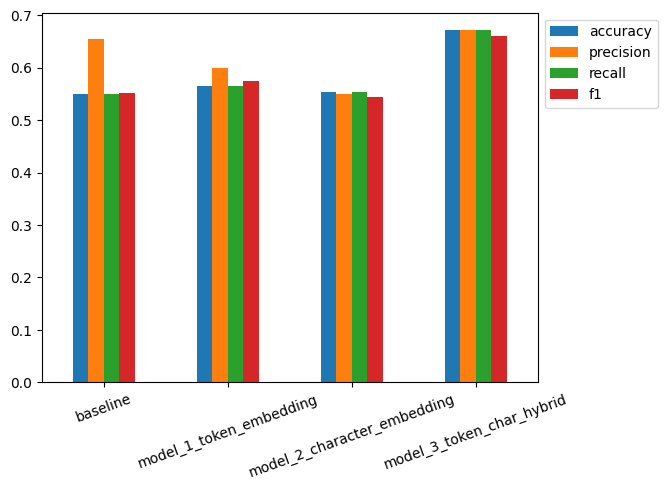

In [112]:
# Plot and compare the scores
all_scores.plot(kind="bar").legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=20)
plt.show()

Seems like Model 3 had the best scores all around.  

The noticable improvements in performance may be attributed to:
* the token-character hybrid embedding architecture of the model
* the use of feature extraction from a pretrained embedding layer from TensorFlow Hub
* a change from a convolutional to a recurrent bidirectional LSTM neural network model
* all of the above
* something else entirely?

### Attempting to Predict the `Score` of a subreddit post based all other Variables

I have built models that use token/character embedding to predict the subreddit label based on the 'title' of a subreddit post.  

The goal now is to build on top of the lastest model and add quantitative variables (upvote_ratio and total_awards_received) in the training process.  

The model should be able to predict the `score` from these mix of categorical and quantitative data.

In [113]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1388 entries, 956 to 1587
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subreddit              1388 non-null   object 
 1   title                  1388 non-null   object 
 2   upvote_ratio           1388 non-null   float64
 3   score                  1388 non-null   float64
 4   total_awards_received  1388 non-null   float64
dtypes: float64(3), object(2)
memory usage: 65.1+ KB


In [184]:
train_upvote_data = train_df["upvote_ratio"].to_numpy()
train_total_awards_received_data = train_df["total_awards_received"].to_numpy()
train_score_data = train_df["score"].to_numpy()
test_upvote_data = test_df["upvote_ratio"].to_numpy()
test_total_awards_received_data = test_df["total_awards_received"].to_numpy()
test_score_data = test_df["score"].to_numpy()

In [161]:
train_df.total_awards_received.value_counts()

total_awards_received
0.0     1331
1.0       38
2.0       11
5.0        2
3.0        2
4.0        2
9.0        1
20.0       1
Name: count, dtype: int64

Pack all data into `tf.data` tensorslices datasets for optimal training

In [193]:
train_token_char_upvote_rewards_data = tf.data.Dataset.from_tensor_slices((train_upvote_data, # line numbers
                                                                train_total_awards_received_data, # total lines
                                                                train_titles, # train tokens
                                                                train_chars)) # train chars
train_token_char_upvote_rewards_labels = tf.data.Dataset.from_tensor_slices(train_score_data) # train labels
train_token_char_upvote_rewards_dataset = tf.data.Dataset.zip((train_token_char_upvote_rewards_data, train_token_char_upvote_rewards_labels)) # combine data and labels
train_pos_char_token_dataset = train_token_char_upvote_rewards_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately
#train_token_char_upvote_rewards_data = train_token_char_upvote_rewards_data.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately
train_token_char_upvote_rewards_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(), dtype=tf.float64, name=None))>

Building the model

In [187]:
# 1. Make the model for token embeddings using the USE pretained token embedding layer
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# 2. Make the mdoel for character embeddings
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
char_outputs = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_outputs)

# 3. Make the model for upvote ratio
upvote_ratio_inputs = layers.Input(shape=len(train_df), dtype=tf.float32, name="upvote_ratio_input")
upvote_ratio_outputs = layers.Dense(32, activation="relu")(upvote_ratio_inputs)
upvote_ratio_model = tf.keras.Model(inputs=upvote_ratio_inputs, outputs=upvote_ratio_outputs)

# 4. Make the model for total rewards received
rewards_inputs = layers.Input(shape=len(train_df), dtype=tf.float32, name="total_rewards_received_input")
rewards_outputs = layers.Dense(32, activation="relu")(rewards_inputs)
rewards_model = tf.keras.Model(inputs=rewards_inputs, outputs=rewards_outputs)

# 5. Combine the token and character inputs
token_char = layers.Concatenate(name="token_char")([token_model.output,
                                                    char_model.output])

# 6. Inermediate Hidden layers
x = layers.Dense(256, activation="relu")(token_char)
x = layers.Dropout(0.5)(x)

# 7. Combine the upvote ratio and total awards received with the token and character embeddings
x = layers.Concatenate(name="token_char_upvote_rewards")([upvote_ratio_model.output,
                                                          rewards_model.output,
                                                          x])

# 8. Create the output layer
output = layers.Dense(1, activation="relu", name="output_layer")(x)

# 9. Stitch everything together
model_4 = tf.keras.Model(inputs=[upvote_ratio_model.input,
                                 rewards_model.input,
                                 token_model.input,
                                 char_model.input],
                                 outputs=output,
                                 name="model_4")

In [188]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 119)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]']      

In [189]:
model_4.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

Training

In [194]:
model_4_history = model_4.fit(train_token_char_upvote_rewards_dataset,
                              epochs=5,
                              verbose=1)

Epoch 1/5


ValueError: in user code:

    File "c:\Users\ellis\TensorFlowProjects\.venv\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ellis\TensorFlowProjects\.venv\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ellis\TensorFlowProjects\.venv\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ellis\TensorFlowProjects\.venv\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\ellis\TensorFlowProjects\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ellis\AppData\Local\Temp\__autograph_generated_file3zcz0iqc.py", line 74, in tf__call
        ag__.if_stmt(ag__.not_(ag__.ld(self)._has_training_argument), if_body_3, else_body_3, get_state_3, set_state_3, ('result', 'training'), 1)
    File "C:\Users\ellis\AppData\Local\Temp\__autograph_generated_file3zcz0iqc.py", line 37, in if_body_3
        result = ag__.converted_call(ag__.ld(f), (), None, fscope)

    ValueError: Exception encountered when calling layer 'USE' (type KerasLayer).
    
    in user code:
    
        File "c:\Users\ellis\TensorFlowProjects\.venv\lib\site-packages\tensorflow_hub\keras_layer.py", line 234, in call  *
            result = f()
    
        ValueError: Shape must be rank 1 but is rank 0 for '{{node text_preprocessor/tokenize/StringSplit/StringSplit}} = StringSplit[skip_empty=true](text_preprocessor/StaticRegexReplace_1, text_preprocessor/tokenize/StringSplit/Const)' with input shapes: [], [].
    
    
    Call arguments received by layer 'USE' (type KerasLayer):
      • inputs=tf.Tensor(shape=(), dtype=string)
      • training=True


**This model requires troubleshooting, and will be left for future work.**